# ProstMorph
MRI/US fusion using VoxelMorph

In [2]:
from pathlib import Path

import neurite as ne
import numpy as np
import tensorflow as tf
import voxelmorph as vxm

from notebooks.utils import SmartDataGenerator
from notebooks.utils import dice
import matplotlib.pyplot as plt
import seaborn as sns

tf.div_no_nan = tf.math.divide_no_nan

### Build model
Set up the VoxelMorph network

In [3]:
def prepare_model(inshape, lambda_param=0.05, gamma_param=0.01):
    enc_nf = [16, 32, 32, 32]
    dec_nf = [32, 32, 32, 32, 32, 16, 16]

    vxm_model = vxm.networks.VxmDenseSemiSupervisedSeg(
        inshape=inshape, nb_labels=1,
        nb_unet_features=[enc_nf, dec_nf],
        seg_downsize=2
    )

    # assigning loss
    bin_centers = np.linspace(0, 1, 32)  # histogram bins, assume normalized images
    loss_mi = vxm.losses.NMI(bin_centers=bin_centers, vol_size=inshape).loss
    loss_dice = vxm.losses.Dice().loss
    losses = [loss_mi, vxm.losses.Grad('l2').loss, loss_dice]
    loss_weights = [1, lambda_param, gamma_param]

    # assigning metrics
    def mi(y_true, y_pred):
        return -loss_mi(y_true, y_pred)
    def dice(y_true, y_pred):
        return -loss_dice(y_true, y_pred)
    metrics = {'transformer': [mi],
               'seg_transformer': [dice]}

    vxm_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss=losses, loss_weights=loss_weights,
        metrics=metrics
    )
    return vxm_model

Create dataset generators

In [4]:
train_test_split = 0.95
train_val_split = 0.90
base_folder = Path(r"C:\Users\ML\Desktop\seba_preprocessed_fusion\numpy_160")
size = (160, 160, 160)

In [5]:
full_data = np.array(list(base_folder.iterdir()))
np.random.shuffle(full_data)
idx = (np.array([train_test_split * train_val_split, train_test_split]) * full_data.shape[0]).astype(int)
train_data, validation_data, test_data = np.split(full_data, idx)
del idx

train_generator = SmartDataGenerator(train_data, dim=size, batch_size=1)
validation_generator = SmartDataGenerator(validation_data, dim=size, batch_size=1)
test_generator = SmartDataGenerator(test_data, dim=size, batch_size=1)

Instantiate network

In [61]:
hyper = {
    'lambda_param': 1.0,
    'gamma_param': 0.5
}

In [62]:
tf.keras.backend.clear_session()
model = prepare_model(inshape=size, lambda_param=hyper['lambda_param'], gamma_param=hyper['gamma_param'])

vxm info: mutual information loss is experimental


# Testing

(just load an input and watch the morphing)

Eventually load the latest checkpoint

In [63]:
checkpoints_dir = Path(f"../results/test_{hyper['lambda_param']}_{hyper['gamma_param']}/checkpoints")
latest_checkpoint = tf.train.latest_checkpoint(checkpoints_dir)
model.load_weights(latest_checkpoint)

Qualitative test for target deformation

In [ ]:
from tqdm import tqdm
from skimage import measure

results = {"dice": [], "error": []}
for i in tqdm(range(len(test_generator))):
    test_input, test_output, mr_targets, us_targets, _ = test_generator(i)

    mr_targets = mr_targets[0]
    us_targets = us_targets[0]
    select_target = 0

    if mr_targets is None or us_targets is None:
        print("no matching targets here")
        continue

    for select_target in range(min(mr_targets.shape[-1], us_targets.shape[-1])):
        test_input_target = mr_targets[np.newaxis, ..., [select_target]]
        test_output_target = us_targets[np.newaxis, ..., [select_target]]
        test_pred_target = model.apply_transform(test_input[0], test_input[1], test_input_target)

        dice_val = dice(test_pred_target, test_output_target)
        error_val = np.linalg.norm((measure.centroid(test_pred_target) - measure.centroid(test_output_target)) / 2)

        results["dice"].append(dice_val)
        results["error"].append(error_val)

results["dice"] = np.array(results["dice"])
results["error"] = np.array(results["error"])

 31%|███▏      | 30/96 [04:20<06:49,  6.21s/it]

no matching targets here


 48%|████▊     | 46/96 [06:13<05:15,  6.31s/it]

In [ ]:
np.savez_compressed(f"../results/results_{hyper['lambda_param']}_{hyper['gamma_param']}", results)

Print and plot stats

In [48]:
results = np.load(f"../results/results_1.0_1.0.npz", allow_pickle=True)['arr_0'].tolist()

In [ ]:
good_dice_threshold = 0.25

good_dice = results['dice'][results['dice'] > good_dice_threshold]
good_error = results['error'][results['dice'] > good_dice_threshold]
decent_dice = results['dice'][results['dice'] > 0]
decent_error = results['error'][results['dice'] > 0]
bad_dice = results['dice'][results['dice'] == 0]
bad_error = results['error'][results['dice'] == 0]

print(f"#targets good dice: {len(good_dice) / len(results['dice']) * 100:.2f}%")
print(f"target good dice: {good_dice.mean() * 100:.2f}±{good_dice.std() * 100:.2f}%")
print(f"target good error: {good_error.mean():.2f}±{good_error.std():.2f}mm")
print()
print(f"#targets decent dice: {len(decent_dice) / len(results['dice']) * 100:.2f}%")
print(f"target decent dice: {decent_dice.mean() * 100:.2f}±{decent_dice.std() * 100:.2f}%")
print(f"target decent error: {decent_error.mean():.2f}±{decent_error.std():.2f}mm")
print()
print(f"#targets bad dice: {len(bad_dice) / len(results['dice']) * 100:.2f}%")
print(f"target bad dice: {bad_dice.mean() * 100:.2f}±{bad_dice.std() * 100:.2f}%")
print(f"target bad error: {bad_error.mean():.2f}±{bad_error.std():.2f}mm")

In [53]:
path_results = Path(r"../results")

n_l = n_g = 5
labels = ('0', '0.5', '1', '2', '3')
good_dice_threshold = 0.25

dice = np.zeros(shape=(n_l, n_g))
error = np.zeros(shape=(n_l, n_g))
n_good_dice = np.zeros(shape=(n_l, n_g))
good_dice = np.zeros(shape=(n_l, n_g))
good_error = np.zeros(shape=(n_l, n_g))
n_decent_dice = np.zeros(shape=(n_l, n_g))
decent_dice = np.zeros(shape=(n_l, n_g))
decent_error = np.zeros(shape=(n_l, n_g))
n_bad_dice = np.zeros(shape=(n_l, n_g))
bad_dice = np.zeros(shape=(n_l, n_g))
bad_error = np.zeros(shape=(n_l, n_g))

def get_index(string):
    if string.startswith('0.0'):
        return 0
    if string == '0.5':
        return 1
    if string == '1.0':
        return 2
    if string == '2.0':
        return 3
    if string == '3.0':
        return 4
    return None

for r in path_results.rglob("results*"):
    _, l, g = r.stem.split("_")
    l, g = get_index(l), get_index(g)
    results = np.load(r, allow_pickle=True)['arr_0'].tolist()
    
    good_dice_vals = results['dice'][results['dice'] > good_dice_threshold]
    good_error_vals = results['error'][results['dice'] > good_dice_threshold]
    decent_dice_vals = results['dice'][results['dice'] > 0]
    decent_error_vals = results['error'][results['dice'] > 0]
    bad_dice_vals = results['dice'][results['dice'] == 0]
    bad_error_vals = results['error'][results['dice'] == 0]

    dice[l, g] = results['dice'].mean() * 100
    error[l, g] = results['error'].mean()
    n_good_dice[l, g] = len(good_dice_vals) / len(results['dice']) * 100
    good_dice[l, g] = good_dice_vals.mean() * 100
    good_error[l, g] = good_error_vals.mean()
    n_decent_dice[l, g] = len(decent_dice_vals) / len(results['dice']) * 100
    decent_dice[l, g] = decent_dice_vals.mean() * 100
    decent_error[l, g] = decent_error_vals.mean()
    n_bad_dice[l, g] = len(bad_dice_vals) / len(results['dice']) * 100
    bad_dice[l, g] = bad_dice_vals.mean() * 100
    bad_error[l, g] = bad_error_vals.mean()

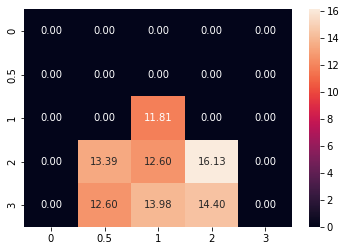

In [60]:
sns.heatmap(n_good_dice, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.show()

In [ ]:
sns.heatmap(good_dice, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.show()

OLD PLOTS

In [ ]:
_ = plt.hist(results["dice"], bins=50, range=(0.0, 1.0))

In [ ]:
plt.hist(results["error"], bins=20)
plt.show()

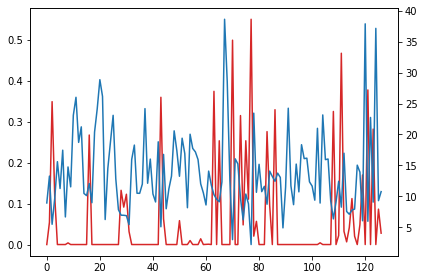

In [36]:
x = list(range(len(results["dice"])))
fig, ax1 = plt.subplots()
ax1.plot(x, results["dice"], 'tab:red')
ax2 = ax1.twinx()
ax2.plot(x, results["error"], 'tab:blue')
fig.tight_layout()
plt.show()

Show slices

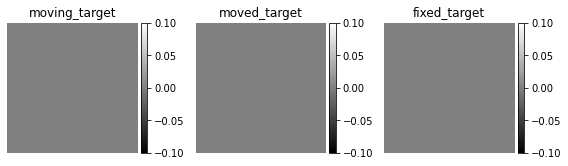

In [15]:
n_slice = 30
images = [img[0, :, :, n_slice * 2].squeeze() for img in [test_input_target, test_pred_target, test_output_target]]
titles = ['moving_target', 'moved_target', 'fixed_target']
_ = ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, grid=(1, 3), width=8)

In [16]:
test_pred = model.predict(test_input)

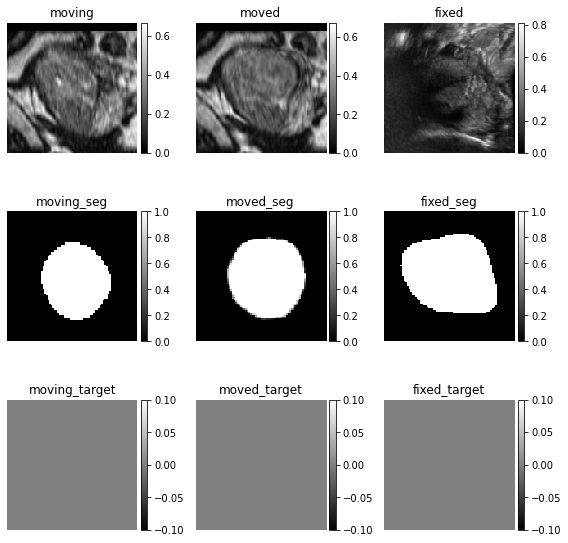

In [17]:
n_slice = 56
images = [img[0, :, :, n_slice * 2].squeeze() for img in [test_input[0], test_pred[0], test_input[1]]]
images += [img[0, :, :, n_slice].squeeze() for img in [test_input[2], test_pred[2], test_output[2]]]
images += [img[0, :, :, n_slice * 2].squeeze() for img in [test_input_target, test_pred_target, test_output_target]]
titles = ['moving', 'moved', 'fixed', 'moving_seg', 'moved_seg', 'fixed_seg', 'moving_target', 'moved_target', 'fixed_target']
_ = ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, grid=(3, 3), width=8)